**Nome:** Claudio Escudero

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from itertools import combinations

from IPython.display import display
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.cross_validation import ShuffleSplit

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
comp_df = pd.read_csv('comp_prices.csv', parse_dates=['DATE_EXTRACTION'])
sales_df = pd.read_csv('sales.csv', parse_dates=['DATE_ORDER'])

In [3]:
print('Concorrentes')
display(comp_df.head(3))
print('Vendas')
display(sales_df.head(3))

Concorrentes


,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE
0,P6,2015-01-30 08:11:38,C3,1898.0,1
1,P6,2015-01-30 08:11:38,C1,1898.0,1
2,P6,2015-01-30 08:11:38,C6,1999.9,1


Vendas


,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
0,P6,2015-08-02,1.0,1808.99
1,P6,2015-08-17,1.0,1674.00
2,P6,2015-08-17,1.0,1673.95


In [4]:
# Colocando na ordem cronológica para melhor visualização
comp_df.sort_values('DATE_EXTRACTION', inplace=True)
sales_df.sort_values('DATE_ORDER', inplace=True)

---
# Exploração de dados dos concorrentes

## Quantidade de extrações por produto em todos os concorrentes

,P6,P2,P7,P9,P3,P8,P1,P5,P4
Qtd,9542,8755,7748,6123,5853,5795,2713,1896,1689


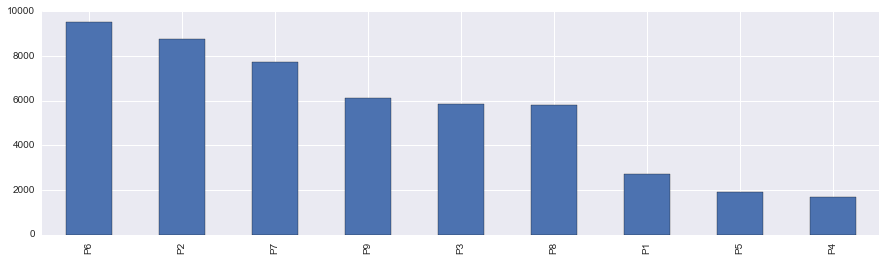

In [5]:
df_temp = comp_df['PROD_ID'].value_counts().sort_values(ascending=False)
display(df_temp.to_frame('Qtd').transpose())
df_temp.plot.bar(figsize=(15,4))
del df_temp

**OBS:** Essa contagem não está considerando quantas vezes os valores foram alterados, sim somente a quantidade de extrações.

## Quantidade de extrações dos concorrentes

,C1,C2,C3,C6,C4,C5
Qtd,9868,9770,9695,8505,7989,4287


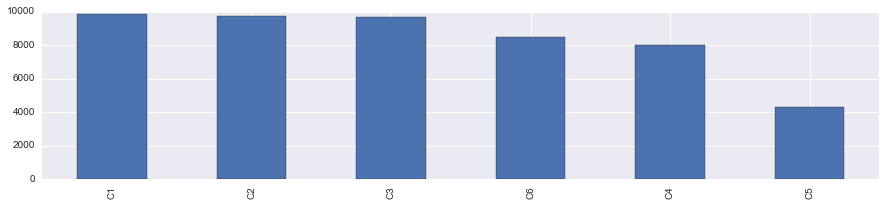

In [6]:
df_temp = comp_df['COMPETITOR'].value_counts().sort_values(ascending=False)
display(df_temp.to_frame('Qtd').transpose())
df_temp.plot.bar(figsize=(15,3))
del df_temp

**OBS:** Essa contagem não está considerando quantas vezes os valores foram alterados, sim somente a quantidade de extrações.

## Quantidade de registros por dia
Para calcular a quantidade de registros por dia, foi agrupado e somado a quantidade de registros com a seguinte chave: **['PROD_ID', 'COMPETITOR', 'PAY_TYPE', 'DATE_ONLY']**.

In [7]:
# Para facilitar o desenvolvimento, iremos criar uma coluna com apenas a data da extração
comp_df['DATE_ONLY'] = pd.to_datetime(comp_df['DATE_EXTRACTION'].apply(lambda x: x.date()))

,2,4,1,3,5,8,6
Qtd,7845,7617,1070,579,173,34,2


Quantidade total: 7


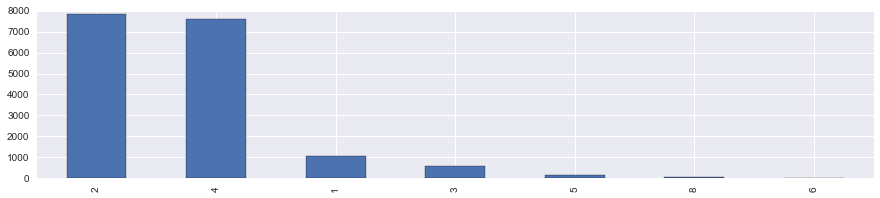

In [8]:
df_temp = comp_df.groupby(['PROD_ID', 'COMPETITOR', 'PAY_TYPE', 'DATE_ONLY']).size().value_counts()
display(df_temp.to_frame('Qtd').transpose())
df_temp.plot.bar(figsize=(15,3))
print('Quantidade total: {}'.format(len(df_temp)))
del df_temp

No documento diz que as extrações foram feitas apenas 2x ao dia, mas na tabela acima podemos verificar que existem casos com mais vezes.

Removendo os registros com valores repetidos dentro do mesmo dia. Assim deixaremos uma base menor e limpa.

,1,2,3,4
Qtd,9084,5863,1710,663


Quantidade total: 4


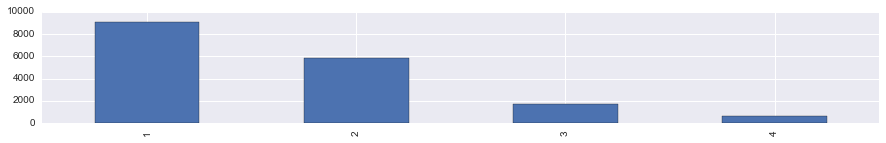

In [9]:
key = ['PROD_ID', 'COMPETITOR', 'PAY_TYPE', 'DATE_ONLY', 'COMPETITOR_PRICE']
df_temp = comp_df.drop_duplicates(key, keep='first')
df_temp = df_temp.groupby(['PROD_ID', 'COMPETITOR', 'PAY_TYPE', 'DATE_ONLY']).size().value_counts()
display(df_temp.to_frame('Qtd').transpose())
df_temp.plot.bar(figsize=(15,2))
print('Quantidade total: {}'.format(len(df_temp)))
del df_temp

Podemos notar que a quantidade de extrações diminuiram, devido os preços inalterados.

Como podemos perceber, existem extrações que os preços foram alterados (até 4x) dentro do mesmo dia.<br />
**OBS:** Foram desconsiderados casos que um produto pode ter iniciado com o preço **X**, depois foi alterado para **Y** e logo em seguida voltou para **X**.<br /><br />
Vamos colocar no nosso dataframe sem as repetições.

In [10]:
comp_df.drop_duplicates(key, keep='first', inplace=True)

## Quantidade de extrações por produto por meses

A tabela abaixo informa a quantidade de extrações por produto para cada linha.

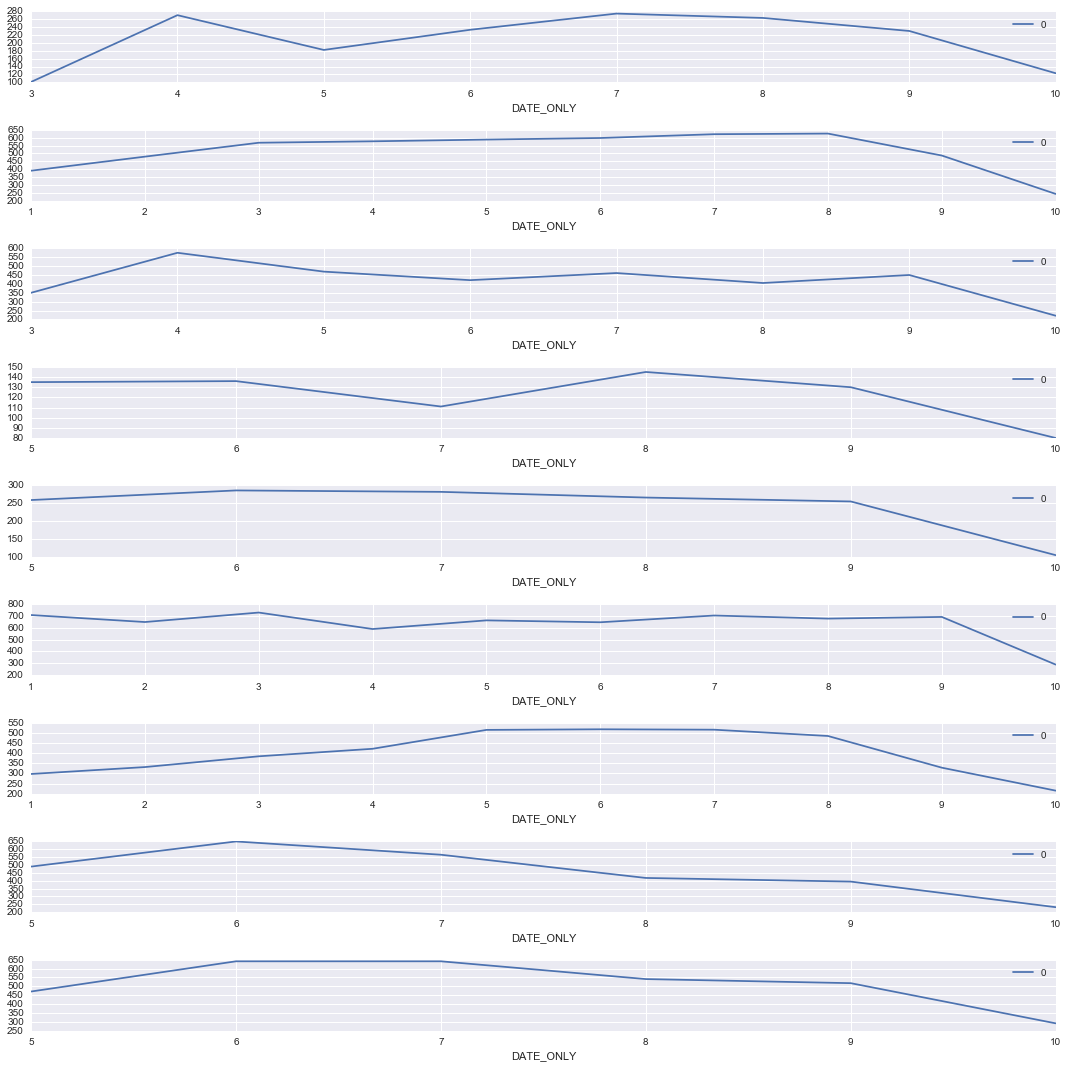

In [11]:
# http://thedailyviz.com/2016/09/17/how-common-is-your-birthday-dailyviz/
# Ou então a primeira parcela do 13o dos aposentados
# pd.groupby(comp_df, by=[comp_df['DATE_ONLY'].dt.month]).value_counts()

fig, axis = plt.subplots(9,1,figsize=(15,15))
i = 0
for prod_id in ['P%d' % c for c in range(1, 10)]:
    df_temp = comp_df.groupby(comp_df[comp_df['PROD_ID'] == prod_id]['DATE_ONLY'].dt.month).size().to_frame()
    df_temp.plot(ax=axis[i])
    i += 1
fig.tight_layout()
# dd = comp_df[['QTD', 'DIA']].groupby('DIA').sum()

Podemos verificar quem nem todos os produtos foram extraídos a partir de janeiro, mas todos foram coletados até outubro.

## Valor médio dos produtos para cada concorrente

A grid de gráficos (violin) abaixo possui o preço dos produtos por concorrente.

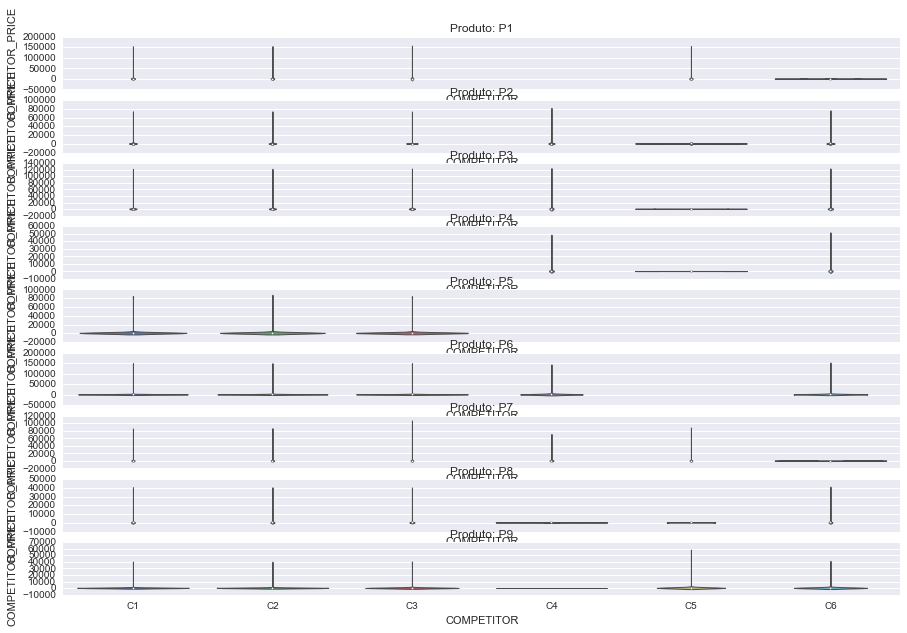

In [12]:
fig, axis = plt.subplots(len(comp_df['PROD_ID'].unique()),1,figsize=(15,10), sharex=True)
i = 0
for prod_id in sorted(comp_df['PROD_ID'].unique()):
    df_temp = comp_df[comp_df['PROD_ID'] == prod_id][['COMPETITOR_PRICE', 'COMPETITOR']]
    df_temp2 = pd.DataFrame(columns=['COMPETITOR_PRICE', 'COMPETITOR'], data=[[np.nan, 'C%d' % c] for c in range(1, 7)])
    df_temp = pd.concat([df_temp, df_temp2])
    df_temp.sort('COMPETITOR', inplace=True)
    
    sns.violinplot(df_temp['COMPETITOR_PRICE'], groupby=df_temp['COMPETITOR'], linewidth=1, ax=axis[i])
    axis[i].set_title('Produto: {}'.format(prod_id))
    i += 1
del df_temp, df_temp2

Podemos perceber existem alguns outliers com os valores extremamente grande.<br />
Esses erros podem ter ocorrido com algum problema de extração ou até mesmo erro de digitação.

Abaixo possui o mesmo gráfico sem os outliers. 

In [13]:
comp_df.drop(comp_df[comp_df['COMPETITOR_PRICE'] > 10000].index, inplace=True)

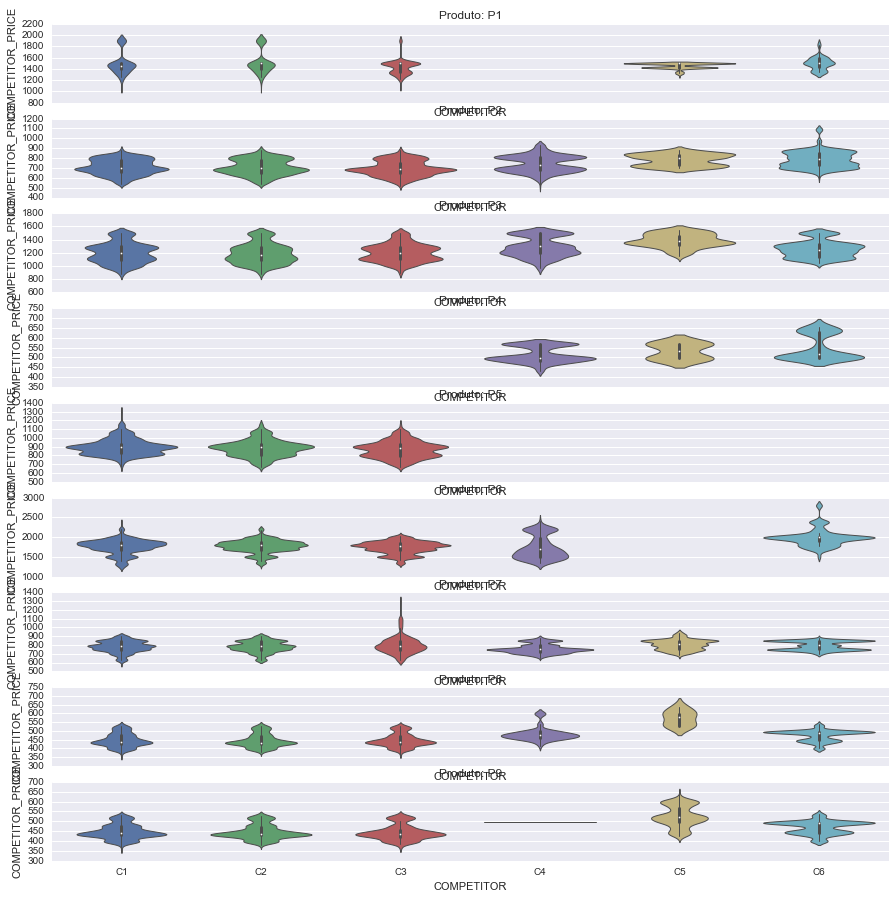

In [14]:
fig, axis = plt.subplots(len(comp_df['PROD_ID'].unique()),1,figsize=(15,15), sharex=True)
i = 0
for prod_id in sorted(comp_df['PROD_ID'].unique()):
    df_temp = comp_df[comp_df['PROD_ID'] == prod_id][['COMPETITOR_PRICE', 'COMPETITOR']]
    df_temp2 = pd.DataFrame(columns=['COMPETITOR_PRICE', 'COMPETITOR'], data=[[np.nan, 'C%d' % c] for c in range(1, 7)])
    df_temp = pd.concat([df_temp, df_temp2])
    df_temp.sort('COMPETITOR', inplace=True)
    
    sns.violinplot(df_temp['COMPETITOR_PRICE'], groupby=df_temp['COMPETITOR'], linewidth=1, ax=axis[i])
    axis[i].set_title('Produto: {}'.format(prod_id))
    i += 1
del df_temp, df_temp2

## Verificando histórico de preço de 1 produto de 1 concorrente

Verificando o histórico do produto P6 e concorrente C6.

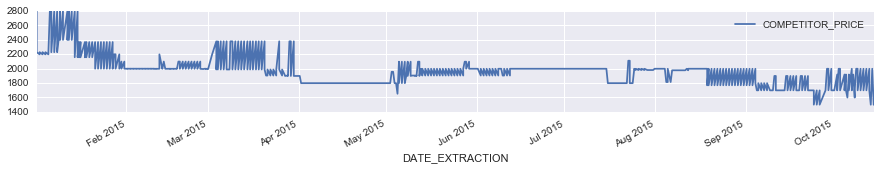

In [15]:
df_tmp = comp_df[(comp_df['COMPETITOR'] == 'C6') & (comp_df['PROD_ID'] == 'P6')]
df_tmp = df_tmp[['DATE_EXTRACTION', 'COMPETITOR_PRICE', 'DATE_ONLY']]
df_tmp = df_tmp.set_index('DATE_EXTRACTION')
df_tmp.plot(figsize=(15, 2))
del df_tmp

Podemos perceber que o histórico teve diversas alterações bem próximos, provavelmente são alterações dentro do mesmo dia.<br />
Vamos normalizar os valores com valor médio do dia e gerar o gráfico novamente.

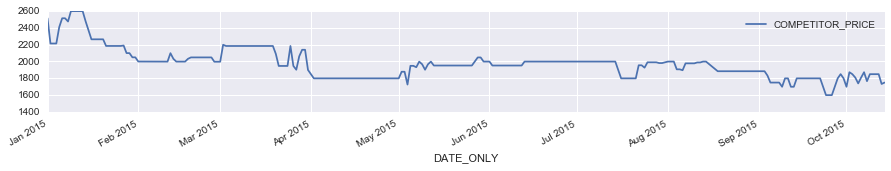

In [16]:
key = ['PROD_ID', 'COMPETITOR', 'DATE_ONLY']
comp_df = comp_df.drop(['DATE_EXTRACTION', 'PAY_TYPE'], axis=1).groupby(key).mean().reset_index()

df_tmp = comp_df[(comp_df['COMPETITOR'] == 'C6') & (comp_df['PROD_ID'] == 'P6')]
df_tmp = df_tmp[['DATE_ONLY', 'COMPETITOR_PRICE']]
df_tmp = df_tmp.set_index('DATE_ONLY')
df_tmp.plot(figsize=(15, 2))
del df_tmp

Gráfico abaixo são com todos os produtos e concorrentes.

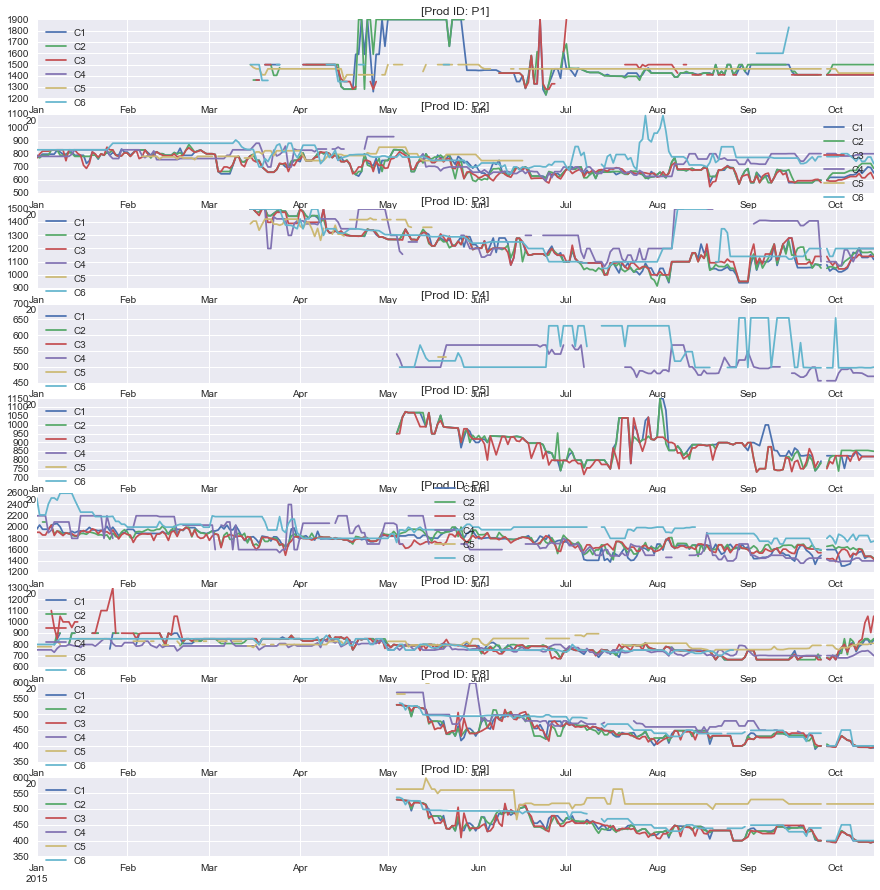

In [17]:
fig, axis = plt.subplots(len(comp_df['PROD_ID'].unique()),1,figsize=(15,15), sharey=False)
i = 0
for prod_id in ['P%d' % c for c in range(1, 10)]:
    df_comp = pd.DataFrame(index=pd.date_range(start='2015-01-01', end='2015-10-14'))
    
    for comp in ['C%d' % c for c in range(1, 7)]:
        df_tmp = comp_df[(comp_df['COMPETITOR'] == comp) & (comp_df['PROD_ID'] == prod_id)]
        df_tmp = df_tmp[['COMPETITOR_PRICE', 'DATE_ONLY']].set_index('DATE_ONLY')
        df_comp[comp] = df_tmp['COMPETITOR_PRICE']
    
    df_comp.plot(title='[Prod ID: %s]' % prod_id, ax=axis[i])
    i += 1
del df_tmp

---
# Exploração de dados das vendas

In [18]:
# Criando a coluna de preço do item vendido. O valor REVENUE é o valor da venda total do pedido
sales_df['PRICE'] = sales_df['REVENUE'] / sales_df['QTY_ORDER']

## Valores dos pedidos de venda por produto

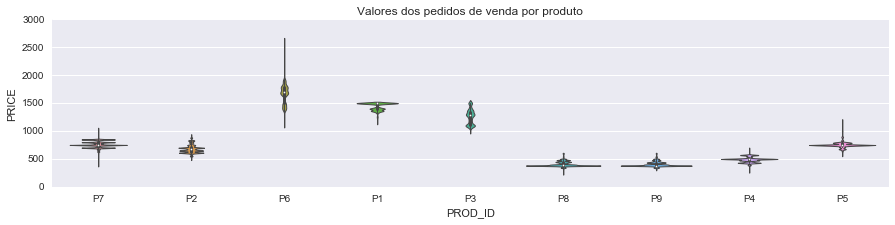

In [19]:
fig, axis = plt.subplots(1,1,figsize=(15,3))
sns.violinplot(sales_df['PRICE'], groupby=sales_df['PROD_ID'], linewidth=1)
axis.set_title(u'Valores dos pedidos de venda por produto')

## Quantidade de quantidades nos pedidos por produto

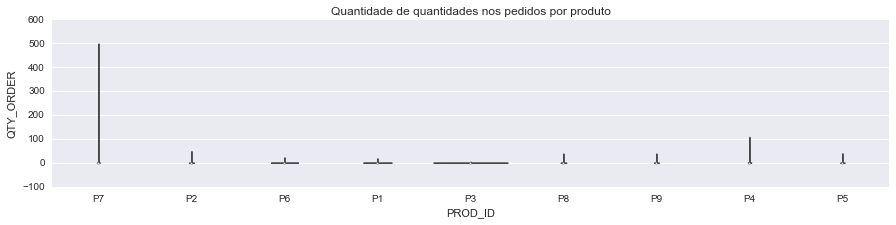

In [20]:
fig, axis = plt.subplots(1,1,figsize=(15,3))
sns.violinplot(sales_df['QTY_ORDER'], groupby=sales_df['PROD_ID'], linewidth=1)
axis.set_title(u'Quantidade de quantidades nos pedidos por produto')

Visualmente existe um pedido com um grande número de quantidade de itens para o produto P7, aproximadamente 500 itens.<br />
Será que vendeu mesmo com essa quantidade? Ou é um erro de extração? Como é um caso raro, resolvi remover das análises e entendi que se encaixa como um valor outlier.

In [21]:
display(sales_df[sales_df['QTY_ORDER'] > 200])
sales_df.drop(sales_df[sales_df['QTY_ORDER'] > 200].index, inplace=True)

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,PRICE
115309,P7,2015-06-25,500.0,368750.0,737.5


Exibindo novamente o gráfico sem o outlier.

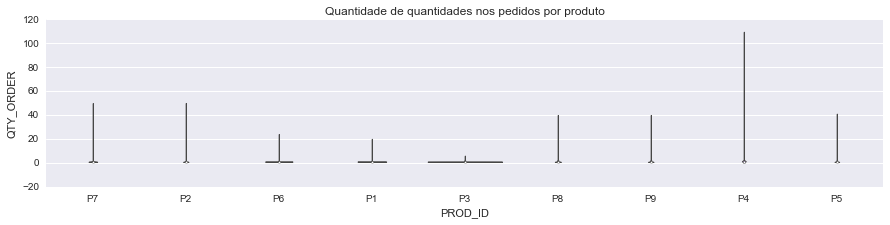

In [22]:
fig, axis = plt.subplots(1,1,figsize=(15,3))
sns.violinplot(sales_df['QTY_ORDER'], groupby=sales_df['PROD_ID'], linewidth=1)
axis.set_title(u'Quantidade de quantidades nos pedidos por produto')

## Normalizando os preços e quantidades de venda por dia

In [23]:
print('Quantidade de pedidos antes da normalização: {}'.format(len(sales_df)))
sales_df = sales_df.groupby(['PROD_ID', 'DATE_ORDER']).agg({'REVENUE': 'sum', 'QTY_ORDER': 'sum'})
sales_df.reset_index(inplace=True)
sales_df['PRICE'] = sales_df['REVENUE'] / sales_df['QTY_ORDER']
print('Quantidade de pedidos depois da normalização: {}'.format(len(sales_df)))

Quantidade de pedidos antes da normalização: 351090
Quantidade de pedidos depois da normalização: 2162


Os pedidos foram agrupados diariamente somando as colunas de quantidades e tirando uma média ponderada dos valores do pedido.<br />
Assim para cada produto podemos ter 1 registro por dia, com o valor médio do produto com a quantidade de vendas durante o dia.

## Valores dos pedidos de venda por produto depois da normalização

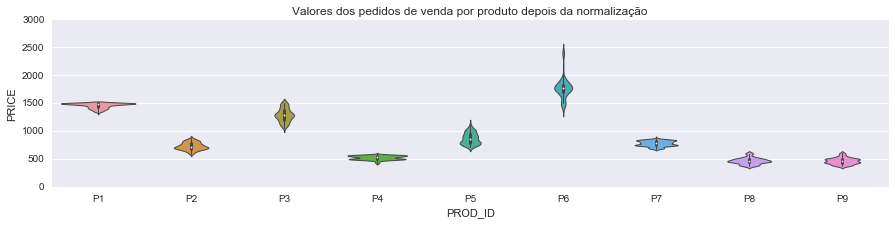

In [24]:
fig, axis = plt.subplots(1,1,figsize=(15,3))
sns.violinplot(sales_df['PRICE'], groupby=sales_df['PROD_ID'], linewidth=1)
axis.set_title(u'Valores dos pedidos de venda por produto depois da normalização')

## Comparando os valores minimos da concorrência e de venda com as suas quantidades

In [25]:
df_comp_prod = {}
i = 0
for prod_id in ['P%d' % c for c in range(1, 10)]:
    df_comp = pd.DataFrame(index=pd.date_range(start='2015-01-01', end='2015-10-14'))
    
    for comp in ['C%d' % c for c in range(1, 7)]:
        df_tmp = comp_df[(comp_df['COMPETITOR'] == comp) & (comp_df['PROD_ID'] == prod_id)]
        df_tmp = df_tmp[['COMPETITOR_PRICE', 'DATE_ONLY']].set_index('DATE_ONLY')
        df_comp[comp] = df_tmp['COMPETITOR_PRICE']
    i += 1
    df_comp_prod[prod_id] = df_comp

In [26]:
df_sale_price = pd.DataFrame(index=pd.date_range(start='2015-01-01', end='2015-10-14'))
df_sale_qtd = pd.DataFrame(index=pd.date_range(start='2015-01-01', end='2015-10-14'))
for prod_id in ['P%d' % c for c in range(1, 10)]:
    df_temp2 = sales_df[sales_df['PROD_ID'] == prod_id].set_index('DATE_ORDER')
    df_sale_price[prod_id] = df_temp2['PRICE']
    df_sale_qtd[prod_id] = df_temp2['QTY_ORDER']

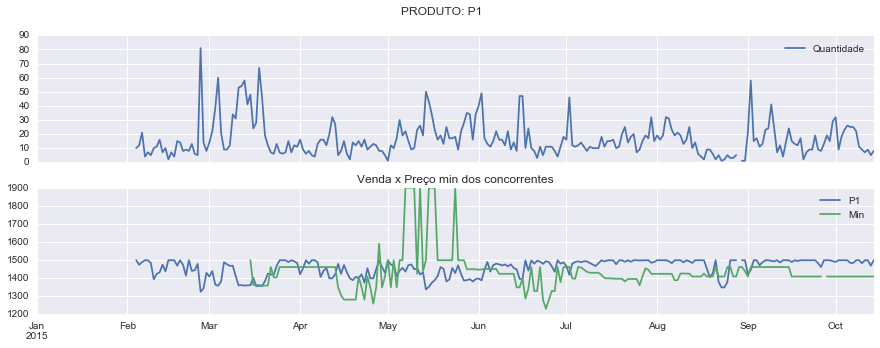

In [27]:
def chart_min_qtd(x):
    
    fig, axis = plt.subplots(2,1,figsize=(15,5), sharex=True)
    
    prod_id = 'P{}'.format(x)
    df_tmp = pd.DataFrame(index=df_sale_price.index)
    df_tmp['Quantidade'] = df_sale_qtd[prod_id]
    
    df_tmp.plot(subplots=True, title='PRODUTO: {}'.format(prod_id), ax=axis[0])
    
    df_min_comp = df_comp_prod[prod_id].min(axis=1)
    df_min_comp.name = 'Min'
    sales_with_min_comp = pd.concat([df_sale_price[prod_id], df_min_comp], axis=1)
    
    sales_with_min_comp.plot(title=u'Venda x Preço min dos concorrentes', ax=axis[1])
    
interact(chart_min_qtd, x=IntSlider(min=1,max=9,step=1,value=None))
None

Acima é possível arrastar o Slider para alterar o produto

---
# Unindo todos os dados em um único DataFrame para cada produto

Criando um DataFrame com o range de **2015-01-01** a **2015-10-14**

In [28]:
remove_comp = []
df_arr = {}
for p in range(1, 10):
    prod_id = 'P%d' % p
    df = pd.DataFrame(index=pd.date_range(start='2015-01-01', end='2015-10-14'))
    df['QTD'] = df_sale_qtd[prod_id]
    df['PRICE'] = df_sale_price[prod_id]
    for c in range(1, 7):
        comp_id = 'C%d' % c
        df[comp_id] = df_comp_prod[prod_id][comp_id]
    df_arr[prod_id] = df

# Treinamento e modelando
## Como foi feito?
O desafio foi desenvolvido com a estratégia de backtesting, a base foi dividida na data 14/SET/2016 (30 dias antes do último registro), assim podemos desenvolver a modelagem com a primeira parte da base com o esperado da segunda parte em diante os resultados continuem a ser semelhantes aos que foram obtidos na primeira parte.<br />
Foi utilizado o método XGBoost com a métrica Root Mean Squared Error.

**A modelagem foi criada e testada em 5 etapas:**
1. Criação das features (Comum para todos os produtos)
2. Seleção das features mais relevantes
3. Hyperparameter no método XGBoost
4. Treinamento com dados de treino do backtesting
5. Backtesting


## Criando features

Features a serem criadas
* Preço da venda
* Preços dos concorrentes
* Preços dos concorrentes do dia anterior
* Diferença do preço da venda para cada concorrentes
* Quantidade vendida dos últimos 3 dias
* Dia
* Semana
* Valores mínimos dos concorrentes
* Valores máximos dos concorrentes
* Meses com mais relevância
* Início de mês
* Final de mês

**OBS**: Para os valores em branco, que provavelmente são produtos ausentes nas lojas concorrências, colocarei o valor de 99999.

In [29]:
max_shift = 3
for p in range(1, 10):
    prod_id = 'P%d' % p

    df_c = df_arr[prod_id][[x for x in df_arr[prod_id].columns if len(x) == 2 and x[0] == 'C']]
    
    df_arr[prod_id]['DIA'] = df_arr[prod_id].index.day
    df_arr[prod_id]['MES'] = df_arr[prod_id].index.month
    df_arr[prod_id]['SEMANA'] = df_arr[prod_id].index.dayofweek
    df_arr[prod_id]['COMP_MIN'] = df_c.min(axis=1)
    df_arr[prod_id]['COMP_MAX'] = df_c.max(axis=1)
    df_arr[prod_id]['MES_TOP'] = [1 if x in [4, 9, 2, 6, 7] else 0 for x in df_arr[prod_id].index.month]
    df_arr[prod_id]['MES_INICIO'] = df_arr[prod_id]['DIA'].apply(lambda x: 1 if x <= 5 else 0)
    df_arr[prod_id]['MES_FINAL'] = df_arr[prod_id]['DIA'].apply(lambda x: 1 if x >= 25 else 0)

    for shift in range(1, max_shift + 1):
        df_arr[prod_id]['QTD_%d' % shift] = df_arr[prod_id]['QTD'].shift(shift)
    
    # Removendo todos os casos que não tem quantidade de venda
    df_arr[prod_id] = df_arr[prod_id][df_arr[prod_id]['QTD'].notnull()]
    df_arr[prod_id].fillna(value=99999, inplace=True)
    df_arr[prod_id] = df_arr[prod_id][max_shift:]

In [30]:
# Criando a métrica Root Mean Squared Error
# Mais detalhes: https://www.kaggle.com/wiki/RootMeanSquaredError
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

RMSE = make_scorer(fmean_squared_error, greater_is_better=False)

In [31]:
data_validacao = '2015-09-14'

## Seleção das features mais relevantes
A seleção de feature foi utilizado o método GradientBoostingRegressor do sklearn para rankear as mais relevantes para cada produto.<br />
A seleção das features foram com o critério de estar acima de 0.005, que é um grau de relevância.

In [32]:
def feature_importances(df, prod_id):
    clf = GradientBoostingRegressor(random_state=0)
    clf.fit(df.drop('QTD', axis=1), df['QTD'])

    index_list = df.drop('QTD', axis=1).columns
    data_list = np.transpose([clf.feature_importances_])
    df_c = pd.DataFrame(index=index_list, columns=['VALOR'], data=data_list).sort('VALOR', ascending=False)
    df_c.plot.bar(figsize=(15,2), title=u'Features relevantes do produto %s' % prod_id)
    return df_c

## Hyperparameter no método XGBoost
O método utilizado foi o XGBoost, é um método simples que facilmente pode ser utilizado para preditivos que normalmente trazem bons resultados.<br />
Foi executado para cada produto a busca de um melhor parâmetro foi utilizado o GridSearchCV do sklearn com os intervalores de:

* learning_rate: [0.1, 0.2, 0.3]
* max_depth: [2, 3, 4, 5, 6, 7, 8, 9]
* min_child_weight: [1, 2, 3, 4, 5, 6, 7, 8, 9]
* gamma: [0.0, 0.1, 0.2]

**OBS:** O ideal é criar uma análise mais profunda para verificação de overfiting.

## Treinamento com dados
Depois de executar o cross-validation e hyperparameter, foi utilizado a configuração encontrada no XGBoost.<br />
Essa configuração pode ser diferente para cada produto, pois eles podem ter comportamentos diferenciados nas séries temporais.

In [33]:
def execute(df, columns):
    dd = df_arr[prod_id]
    dd = dd[dd.index < data_validacao]
    data = dd.drop('QTD', axis=1)[columns]
    target = dd['QTD']

    cv = ShuffleSplit(len(data), n_iter=3, test_size=0.2, random_state=0)

    # params = {
    #     'learning_rate': [0.2],
    #     'max_depth': [4],
    #     'min_child_weight': [6],
    #     'gamma': [0]
    # }
    params = {
        'learning_rate': [0.1, 0.2, 0.3],
        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
        'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9],
        'gamma': [i/10.0 for i in range(0,3)],
    }

    # clf = RandomForestRegressor(random_state=1)
    clf = xgb.XGBRegressor(seed=1)
    clf = GridSearchCV(clf, params, scoring=RMSE, verbose=0, cv=cv, refit=False, n_jobs=1)
    clf.fit(data, target)

    rfc_params = clf.best_params_
    return [clf.best_params_, clf.best_score_]

## Backtesting
Com os treinamentos finalizados para cada produto, foram testados com os dados do backtesting e foi gerado um gráfico comparativo com o valor realizado e previsto.<br />
O resultado será mostrado na sessão de “Resultados”.

In [34]:
def execute_backtesting(df, params, columns, prod_id):
    dfd = df[df.index < data_validacao]
    dft = df[df.index >= data_validacao]

    # clf = RandomForestRegressor(random_state=1, **rfc_params)
    clf = xgb.XGBRegressor(seed=1, **params)
    clf.fit(dfd.drop('QTD', axis=1)[columns], dfd['QTD'])

    dft['QTD_PRED'] = clf.predict(dft.drop('QTD', axis=1)[columns])
    
    dft.sort_index(inplace=True)
    fig, axis = plt.subplots(2,1,figsize=(15,5))
    dft[['QTD', 'QTD_PRED']].plot(kind='line', ax=axis[0], title=u'Validação do produto %s' % prod_id)
    dft[['QTD', 'QTD_PRED']].plot(kind='bar', ax=axis[1])

In [49]:
def execute_process(prod_id):
    df_prod = df_arr[prod_id]
    fi = feature_importances(df_prod, prod_id)
    columns = fi[fi['VALOR'] > 0.005].index
    print 'Produto: %s' % prod_id
    print 'Colunas utilizadas'
    print columns
    print ''
    ret_exec = execute(df_prod, columns)
    best_params = ret_exec[0]
    print 'Parâmetros utilizados no XGBoost'
    print best_params
    print ''
    execute_backtesting(df_prod, best_params, columns, prod_id)

Produto: P1
Colunas utilizadas
Index([u'PRICE', u'DIA', u'QTD_1', u'QTD_3', u'QTD_2', u'SEMANA', u'MES',
       u'C2', u'COMP_MAX', u'COMP_MIN', u'C1', u'C5', u'C6', u'C3',
       u'MES_INICIO'],
      dtype='object')

Parâmetros utilizados no XGBoost
{'learning_rate': 0.1, 'max_depth': 4, 'gamma': 0.0, 'min_child_weight': 5}



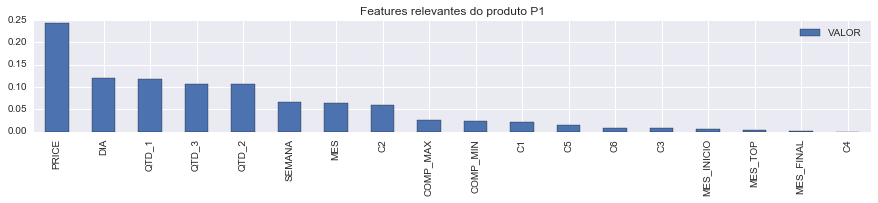

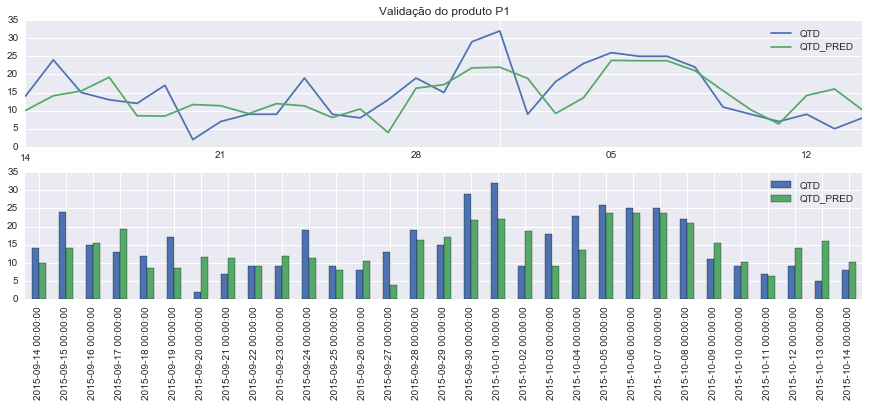

In [41]:
execute_process('P1')

Produto: P2
Colunas utilizadas
Index([u'PRICE', u'QTD_1', u'MES', u'QTD_2', u'QTD_3', u'C6', u'C3', u'C2',
       u'C4', u'COMP_MIN', u'SEMANA', u'DIA', u'C5', u'C1', u'COMP_MAX'],
      dtype='object')

Parâmetros utilizados no XGBoost
{'learning_rate': 0.1, 'max_depth': 2, 'gamma': 0.0, 'min_child_weight': 1}



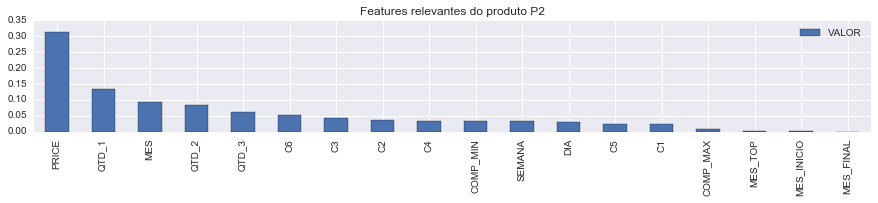

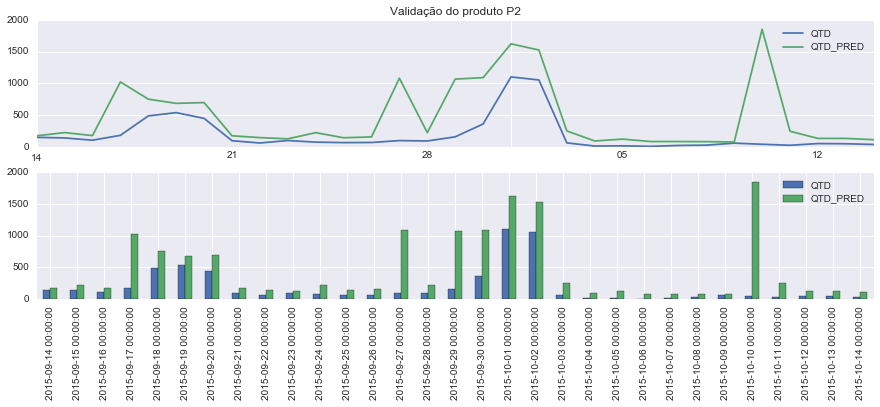

In [42]:
execute_process('P2')

Produto: P3
Colunas utilizadas
Index([u'PRICE', u'QTD_1', u'QTD_3', u'DIA', u'QTD_2', u'MES', u'C6'], dtype='object')

Parâmetros utilizados no XGBoost
{'learning_rate': 0.1, 'max_depth': 2, 'gamma': 0.0, 'min_child_weight': 1}



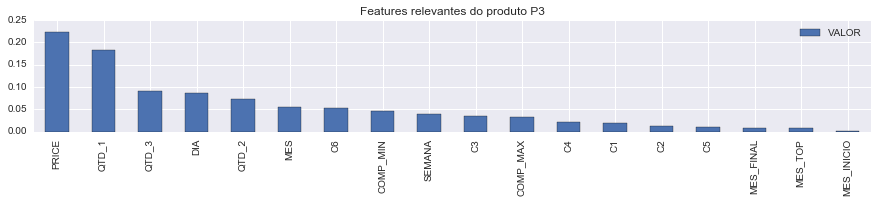

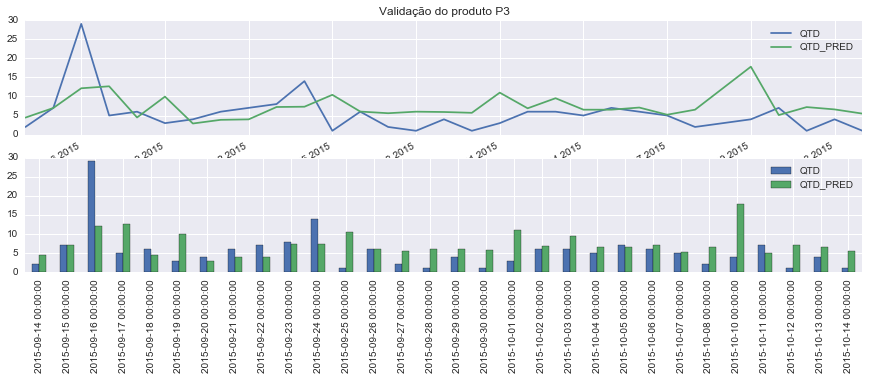

In [51]:
execute_process('P3')

Produto: P4
Colunas utilizadas
Index([u'PRICE', u'QTD_1', u'QTD_3', u'C6', u'QTD_2', u'DIA', u'COMP_MIN',
       u'COMP_MAX', u'MES', u'SEMANA', u'C4', u'MES_INICIO', u'MES_FINAL',
       u'C5'],
      dtype='object')

Parâmetros utilizados no XGBoost
{'learning_rate': 0.1, 'max_depth': 2, 'gamma': 0.0, 'min_child_weight': 1}



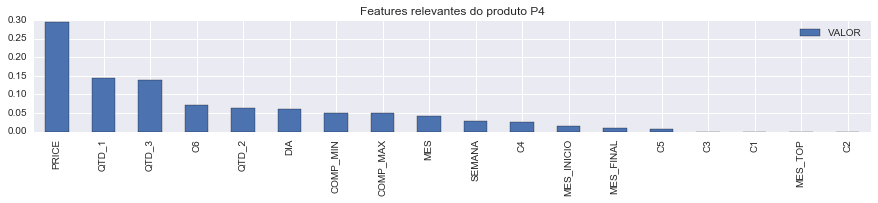

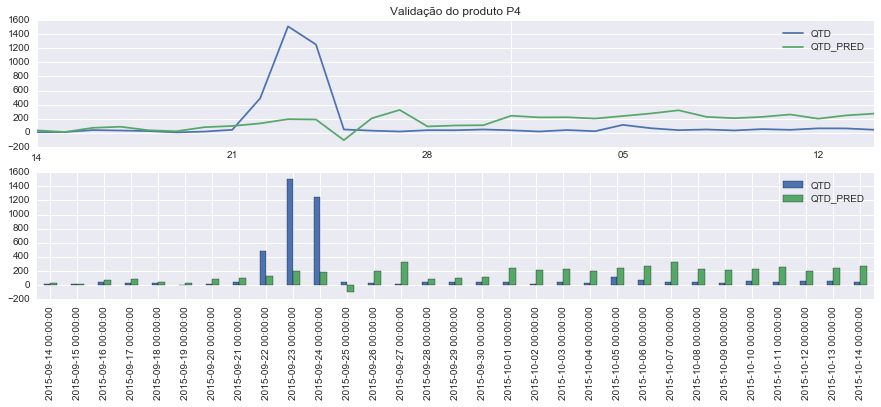

In [44]:
execute_process('P4')

Produto: P5
Colunas utilizadas
Index([u'PRICE', u'QTD_1', u'COMP_MAX', u'QTD_2', u'C3', u'QTD_3', u'COMP_MIN',
       u'C2', u'DIA', u'C1', u'MES', u'SEMANA', u'MES_TOP'],
      dtype='object')

Parâmetros utilizados no XGBoost
{'learning_rate': 0.2, 'max_depth': 6, 'gamma': 0.1, 'min_child_weight': 1}



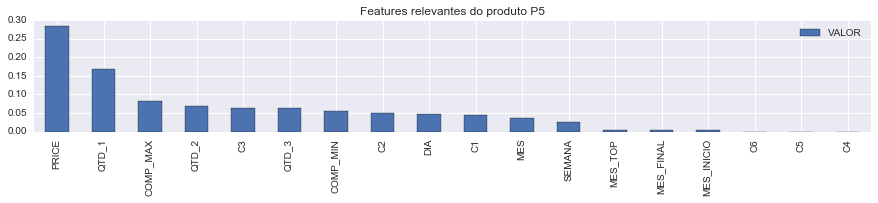

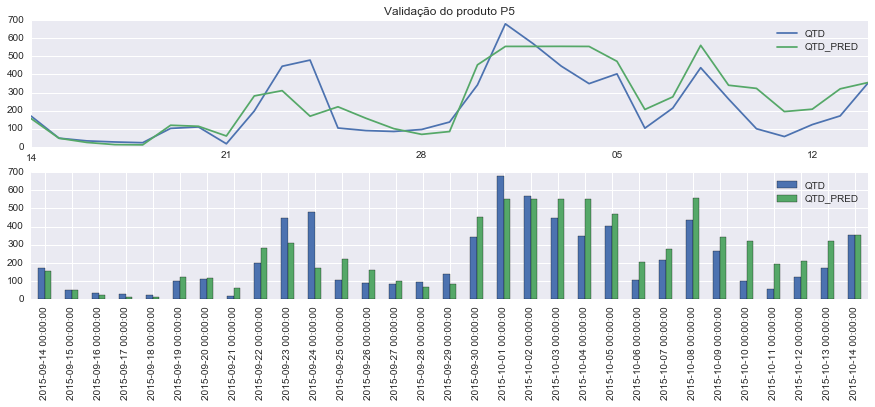

In [45]:
execute_process('P5')

Produto: P6
Colunas utilizadas
Index([u'PRICE', u'C1', u'QTD_1', u'DIA', u'C2', u'QTD_2', u'C3', u'MES',
       u'C6', u'QTD_3', u'COMP_MIN', u'COMP_MAX', u'C4', u'SEMANA',
       u'MES_FINAL'],
      dtype='object')

Parâmetros utilizados no XGBoost
{'learning_rate': 0.1, 'max_depth': 6, 'gamma': 0.0, 'min_child_weight': 6}



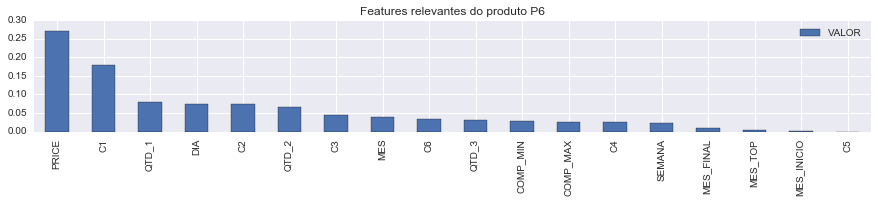

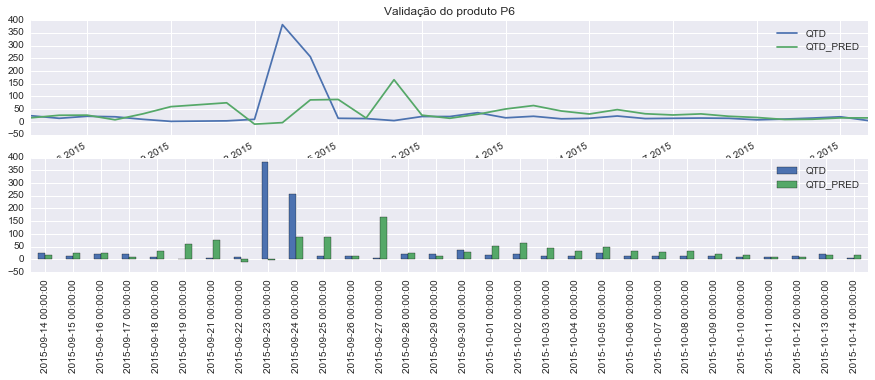

In [46]:
execute_process('P6')

Produto: P7
Colunas utilizadas
Index([u'PRICE', u'QTD_1', u'QTD_3', u'MES', u'QTD_2', u'SEMANA', u'COMP_MAX',
       u'C4', u'C6', u'C2', u'C5', u'COMP_MIN', u'DIA', u'C1', u'C3'],
      dtype='object')

Parâmetros utilizados no XGBoost
{'learning_rate': 0.1, 'max_depth': 2, 'gamma': 0.0, 'min_child_weight': 1}



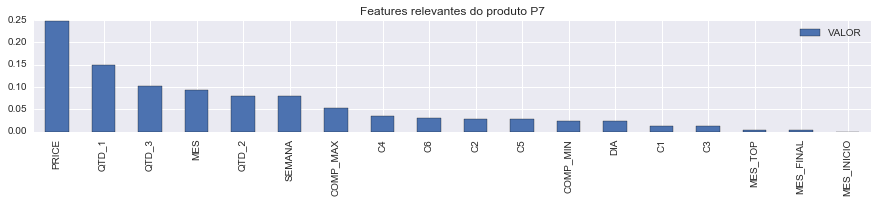

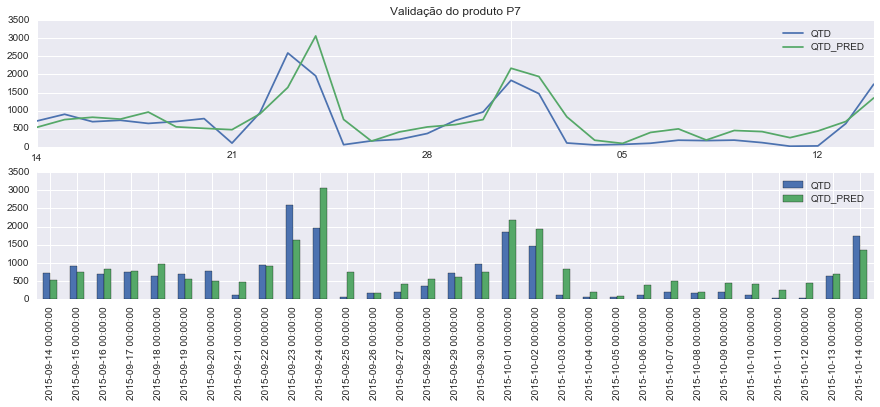

In [40]:
execute_process('P7')

Produto: P8
Colunas utilizadas
Index([u'PRICE', u'QTD_1', u'QTD_2', u'DIA', u'COMP_MAX', u'QTD_3', u'C3',
       u'COMP_MIN', u'SEMANA', u'C2', u'C6', u'MES', u'C1', u'C5', u'MES_TOP',
       u'C4'],
      dtype='object')

Parâmetros utilizados no XGBoost
{'learning_rate': 0.1, 'max_depth': 2, 'gamma': 0.0, 'min_child_weight': 1}



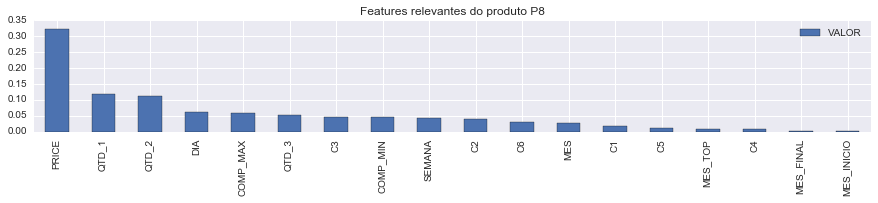

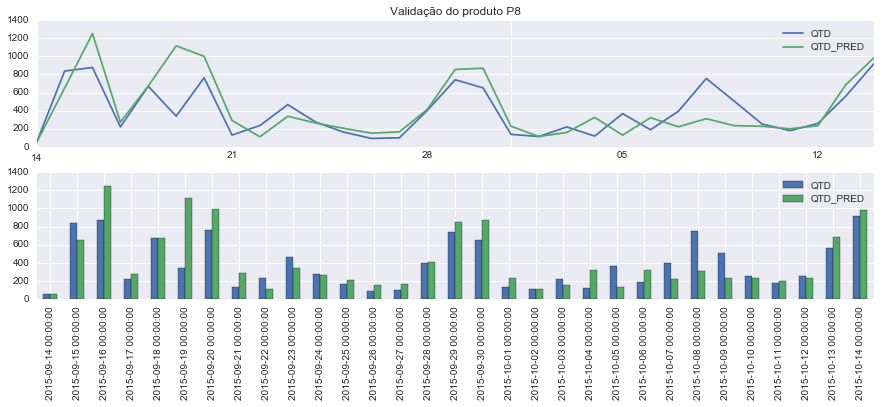

In [47]:
execute_process('P8')

Produto: P9
Colunas utilizadas
Index([u'PRICE', u'QTD_1', u'QTD_3', u'QTD_2', u'SEMANA', u'DIA', u'C6', u'C2',
       u'COMP_MIN', u'C3', u'MES_TOP', u'C4', u'C1', u'MES', u'COMP_MAX',
       u'C5'],
      dtype='object')

Parâmetros utilizados no XGBoost
{'learning_rate': 0.1, 'max_depth': 6, 'gamma': 0.0, 'min_child_weight': 5}



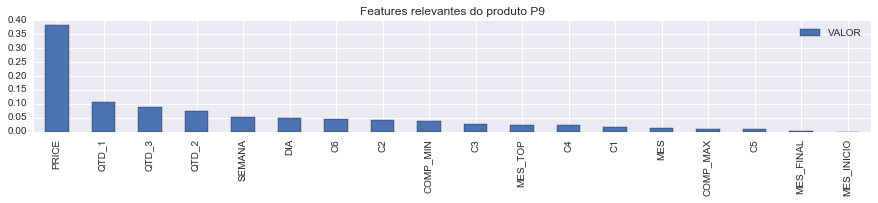

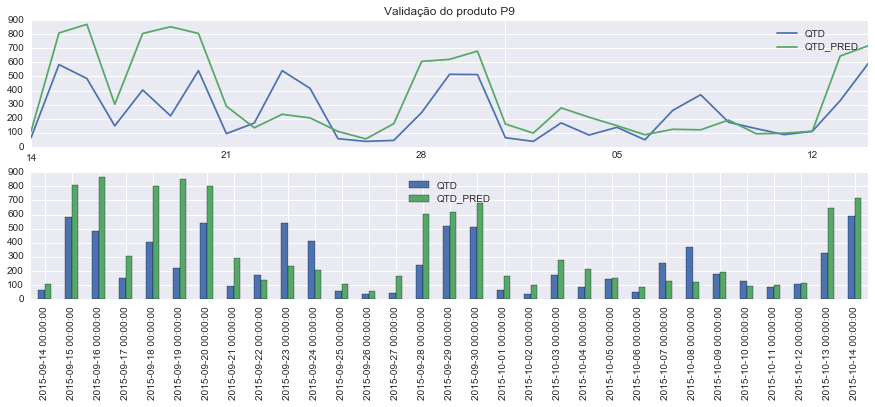

In [48]:
execute_process('P9')

---
# Considerações finais e melhorias

Visualizando os resultados, podemos perceber que a curva de previsão tende a andar próximo com a curva de realizado, com exceção de P3, P6 e P4. Nestes casos com bastante diferença podemos usar técnicas que melhor se encaixam nas séries.

É possível melhorar a modelagem? Sim e bastante. Por questão de tempo e esforço foi desenvolvido superficialmente em todas as etapas e processos. Citarei abaixo alguns pontos para explorações e melhorias.


**Diferentes modelos**<br />
Existem modelos mais específicos para séries temporais, por exemplo: ARIMA, Croston, Auto-ARIMA (R), etc. Além de fornecerem intervalos de confiança, eles são padrões de mercado para séries temporais.

**Seleção de outliers**<br />
Uso de pacotes do sklearn para detecção de outliers.

**Criação de features**<br />
Poderia ter criado features com uso de auto regressivo, eles são bons para series sazonais. Mas se for usar o ARIMA por exemplo, são serão necessários criar essas features.

**Seleção de features**<br />
O critério de seleção de feature foi utilizado de forma mais simples. É importante selecionar quais features são melhoras se trabalharem juntas, se existem features que prejudicam as outras, etc.

**Adição de feriados**<br />
Será que feriados fazem as vendas aumentarem? É bom ter uma exploração de dados neste assunto.

**Cross-validations**<br />
O cross-validation escolheu registros de uma forma aleatórios, como se trata de séries temporais, o ideal é treinar os dados de acordo com a linha do tempo e testando o resultado com as métricas.

**Diferentes métricas**<br />
Poderia ser usado as métricas WMAPE/MAPE, pois são padrões de mercado em séries temporais.

**Overfiting**<br />
	Criar estratégias de evitar overfiting.
